In [1]:
import numpy
import math
import sys
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from os import listdir
from os.path import isfile, join

Using TensorFlow backend.


##  Create function to read CIFAR-10 dataset

In [2]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

In [3]:
from scipy.misc import imsave
def ndarray2image (arr_data, image_fn):
	imsave(image_fn, arr_data)

In [14]:
# set dataset path
dataset_path = '../cnn/cifar_10/'
# define the information of images which can be obtained from official website
height, width, dim = 32, 32, 3
classes = 10

## Check data dimention

In [11]:
''' read training data '''
# get the file names which start with "data_batch" (training data)
train_fns = [fn for fn in listdir(dataset_path) if isfile(join(dataset_path, fn)) & fn.startswith("data_batch")]
# list sorting
train_fns.sort()
# make a glace about the training data
fn = train_fns[0]
print fn
raw_data = unpickle(dataset_path + fn)
print type(raw_data)
raw_data_keys = raw_data.keys()
print raw_data['data'].shape

data_batch_1
<type 'dict'>
(10000, 3072)


## Read training data 

`train_fns[0:3]` means only read the first three part, because the training time is to long

In [36]:
# concatenate pixel (px) data into one ndarray [img_px_values]
# concatenate label data into one ndarray [img_lab]
img_px_values = 0
img_lab = 0
for fn in train_fns[0:3]:
    raw_data = unpickle(dataset_path + fn)
    if fn == train_fns[0]:
        img_px_values = raw_data['data']
        img_lab = raw_data['labels']
    else:
        img_px_values = numpy.vstack((img_px_values, raw_data['data']))
        img_lab = numpy.hstack((img_lab, raw_data['labels']))

## Transfer data to training foramt

In [37]:
# convert 1d-ndarray (0:3072) to 3d-ndarray(32,32,3)
X_train = numpy.asarray([numpy.dstack((r[0:(width*height)].reshape(height,width),
									   r[(width*height):(2*width*height)].reshape(height,width),
									   r[(2*width*height):(3*width*height)].reshape(height,width)
									 )) for r in img_px_values])

Y_train = np_utils.to_categorical(numpy.array(img_lab), classes)

# check is same or not!
# lab_eql = numpy.array_equal([(numpy.argmax(r)) for r in Y_train], numpy.array(img_lab))

# draw one image from the pixel data
ndarray2image(X_train[0],"test_image.png")


print 'X_train shape:', X_train.shape
print 'Y_train shape:', Y_train.shape

X_train shape: (30000, 32, 32, 3)
Y_train shape: (30000, 10)


## Print image to check format accurcy

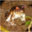

In [41]:
import matplotlib.pyplot as plt
from IPython.display import Image, display
display(Image(filename='test_image.png'))

In [42]:
test_fns = [fn for fn in listdir(dataset_path) if isfile(join(dataset_path, fn)) & fn.startswith("test_batch")]

# read testing data
raw_data = unpickle(dataset_path + fn)

# type of raw data
print type(raw_data)

# check keys of testing data
raw_data_keys = raw_data.keys()
# ['data', 'labels', 'batch_label', 'filenames']

img_px_values = raw_data['data']

# check dimensions of data
print "dim(data)", numpy.array(img_px_values).shape

img_lab = raw_data['labels']
# check dimensions of labels
print "dim(labels)",numpy.array(img_lab).shape
# dim(data) (10000,)

<type 'dict'>
dim(data) (10000, 3072)
dim(labels) (10000,)


In [43]:
X_test = numpy.asarray([numpy.dstack((r[0:(width*height)].reshape(height,width),
									  r[(width*height):(2*width*height)].reshape(height,width),
									  r[(2*width*height):(3*width*height)].reshape(height,width)
									)) for r in img_px_values])

Y_test = np_utils.to_categorical(numpy.array(raw_data['labels']), classes)

## scale image data to range [0, 1]

In [44]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

# print the dimension of training data
print 'X_test shape:', X_test.shape
print 'Y_test shape:', Y_test.shape

X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


## Define CNN Model

In [45]:
'''CNN model'''
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=X_train[0].shape))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(classes))
model.add(Activation('softmax'))

## setting optimizer

In [46]:
learning_rate = 0.01
learning_decay = 0.01/32
sgd = SGD(lr=learning_rate, decay=learning_decay, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [47]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 32, 32, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 30, 30, 32)    9248        activation_5[0][0]               
____________________________________________________________________________________________________
activation_6 (Activation)        (None, 30, 30, 32)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [49]:
''' training'''
batch_size = 128
epoch = 16

## Start to train

In [50]:
# validation data comes from testing data
fit_log = model.fit(X_train, Y_train, batch_size=batch_size,
	                nb_epoch=epoch, validation_data=(X_test, Y_test), shuffle=True)

Train on 30000 samples, validate on 10000 samples
Epoch 1/16
30000/30000 [==============================] - 143s - loss: 2.0316 - acc: 0.2527 - val_loss: 1.7414 - val_acc: 0.3976
Epoch 2/16
30000/30000 [==============================] - 142s - loss: 1.6912 - acc: 0.3964 - val_loss: 1.5101 - val_acc: 0.4667
Epoch 3/16
30000/30000 [==============================] - 146s - loss: 1.5136 - acc: 0.4538 - val_loss: 1.3919 - val_acc: 0.5023
Epoch 4/16
30000/30000 [==============================] - 138s - loss: 1.3940 - acc: 0.5007 - val_loss: 1.3125 - val_acc: 0.5401
Epoch 5/16
30000/30000 [==============================] - 132s - loss: 1.2957 - acc: 0.5344 - val_loss: 1.2372 - val_acc: 0.5572
Epoch 6/16
30000/30000 [==============================] - 139s - loss: 1.2279 - acc: 0.5582 - val_loss: 1.1972 - val_acc: 0.5763
Epoch 7/16
30000/30000 [==============================] - 144s - loss: 1.1552 - acc: 0.5869 - val_loss: 1.1444 - val_acc: 0.5936
Epoch 8/16
30000/30000 [=======================

## Save model & save history

In [52]:
'''saving training history'''
import csv
history_fn = 'M3_cp32_3_cp32_3_m_d512.csv'
with open(history_fn, 'wb') as csv_file:
	w = csv.writer(csv_file)
	temp = numpy.array(fit_log.history.values())
	w.writerow(fit_log.history.keys())
	for i in range(temp.shape[1]):
		w.writerow(temp[:,i])

'''saving model'''
from keras.models import load_model
model.save('M3_cp32_3_cp32_3_m_d512.h5')
del model

'''loading model'''
model = load_model('M3_cp32_3_cp32_3_m_d512.h5')

In [53]:
'''prediction'''
pred = model.predict_classes(X_test, batch_size, verbose=0)
ans = [numpy.argmax(r) for r in Y_test]

# caculate accuracy rate of testing data
acc_rate = sum(pred-ans == 0)/float(pred.shape[0])

print "Accuracy rate:", acc_rate

Accuracy rate: 0.6517
